In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc

## breau と breau_balance 
1. breau_balance を1hot, count, avgする。
2. breau を 1hot, カウント
3. マージ

## prev, POS_CASH, credit_card_balance
1. 1hot, average, count 

## data に統合

In [2]:
def build_model_input():
    buro_bal = pd.read_csv('../input/bureau_balance.csv')
    print('Buro bal shape : ', buro_bal.shape)
    
    # 1hot encoding
    print('transform to dummies')
    buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)
    
    # 'SK_ID_BUREAU', 'MONTHS_BALANCE'をカウント
    print('Counting buros')
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
    
    # balance をaverage
    print('averaging buro bal')
    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    del buro_bal
    gc.collect()
    
    print('Read Bureau')
    buro = pd.read_csv('../input/bureau.csv')
    
    # bureau を 1hot encoding
    print('Go to dummies')
    buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
    buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
    buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
    
    # 1hotをマージ
    buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
    # buro_full.columns = ['buro_' + f_ for f_ in buro_full.columns]
    
    del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
    gc.collect()
    
    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    
    # breauの数のカウント
    print('Counting buro per SK_ID_CURR')
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
    
    print('Averaging bureau')
    avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    print(avg_buro.head())
    
    del buro, buro_full
    gc.collect()
    
    print('Read prev')
    prev = pd.read_csv('../input/previous_application.csv')
    
    prev_cat_features = [
        f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    ]
    
    print('Go to dummies')
    prev_dum = pd.DataFrame()
    for f_ in prev_cat_features:
        prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)
    
    prev = pd.concat([prev, prev_dum], axis=1)
    
    del prev_dum
    gc.collect()
    
    print('Counting number of Prevs')
    nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
    
    print('Averaging prev')
    avg_prev = prev.groupby('SK_ID_CURR').mean()
    print(avg_prev.head())
    del prev
    gc.collect()
    
    print('Reading POS_CASH')
    pos = pd.read_csv('../input/POS_CASH_balance.csv')
    
    print('Go to dummies')
    pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
    
    print('Compute nb of prevs per curr')
    nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    print('Go to averages')
    avg_pos = pos.groupby('SK_ID_CURR').mean()
    
    del pos, nb_prevs
    gc.collect()
    
    print('Reading CC balance')
    cc_bal = pd.read_csv('../input/credit_card_balance.csv')
    
    print('Go to dummies')
    cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)
    
    nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    print('Compute average')
    avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
    
    del cc_bal, nb_prevs
    gc.collect()
    
    print('Reading Installments')
    inst = pd.read_csv('../input/installments_payments.csv')
    nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_inst = inst.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]
    
    print('Read data and test')
    data = pd.read_csv('../input/application_train.csv')
    test = pd.read_csv('../input/application_test.csv')
    print('Shapes : ', data.shape, test.shape)
    
    y = data['TARGET']
    del data['TARGET']
    
    categorical_feats = [
        f for f in data.columns if data[f].dtype == 'object'
    ]
    categorical_feats
    for f_ in categorical_feats:
        data[f_], indexer = pd.factorize(data[f_])
        test[f_] = indexer.get_indexer(test[f_])
        
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()

    return data, test, y

# 学習モデル
5fold CV
LGBM

In [4]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            boosting_type='gbdt',
            is_unbalance=True,
            n_estimators=2329,
            learning_rate=0.05143640081015152,
            num_leaves=127,
            colsample_bytree=.86,
            subsample=.790909090909091,
#             max_depth=7,
            reg_alpha=.3857142857142857,
            reg_lambda=.4775510204081632,
#             min_split_gain=.01,
#             min_child_weight=2,
            min_child_samples=465,
            subsample_for_bin=80000,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds

    return oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df
    

In [5]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [6]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')

In [7]:
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig('recall_precision_curve.png')

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data and test
Shapes :  (307511, 122) (48744, 121)
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.861902	valid_1's auc: 0.777391
[200]	training's auc: 0.914509	valid_1's auc: 0.78173
[300]	training's auc: 0.946843	valid_1's auc: 0.781592
Early stopping, best iteration is:
[271]	training's auc: 0.938906	valid_1's auc: 0.782265
Fold  1 AUC : 0.782265
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.862381	valid_1's auc: 0.777058
[200]	training's auc: 0.914562	valid_1's auc: 0.781047
[300]	training's auc: 0.94671	valid_1's auc: 0.780613
Early stopping, best iteration is:
[228]	training's auc: 0.925459	valid_1's auc: 0.781545
Fold  2 AUC : 0.781545
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.862431	valid_1's auc: 0.777366
[200]	training's a

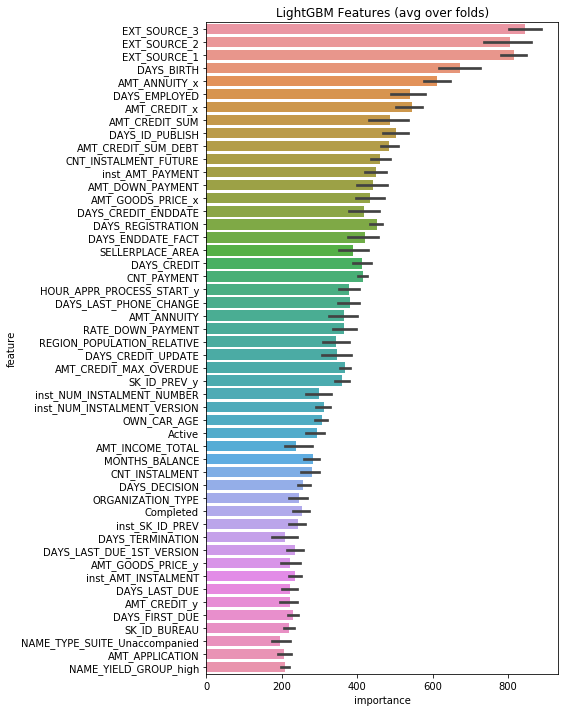

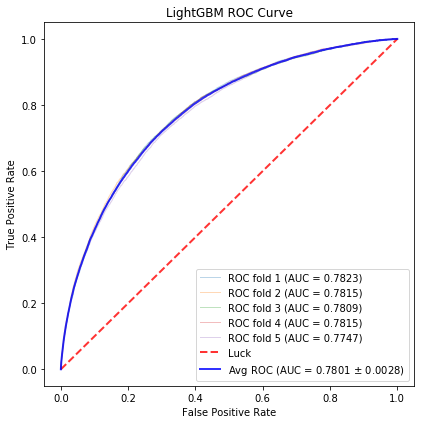

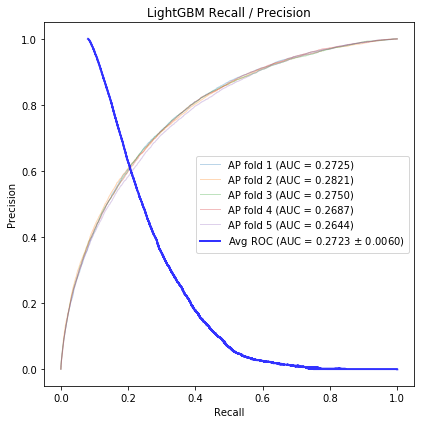

In [8]:
if __name__ == '__main__':
    gc.enable()
    # Build model inputs
    data, test, y = build_model_input()
    # Create Folds
    folds = KFold(n_splits=5, shuffle=True, random_state=546789)
    # Train model and get oof and test predictions
    oof_preds, test_preds, importances = train_model(data, test, y, folds)
    # Save test predictions
    test_preds.to_csv('ori_randomgrid_submission.csv', index=False)
    # Display a few graphs
    folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
    display_importances(feature_importance_df_=importances)
    display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
    display_precision_recall(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
    